In [2]:
from __future__ import annotations
from typing import List

import os
import re
import h5py
import numpy as np
import configparser
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Constant

In [3]:
HEADER_SIZE = 1159544
METADATA_SIZE = 554
SV_SCAN_SIZE = 25930
VOC_SCAN_SIZE = 17290
BB_SCAN_SIZE = 8650
TRANSPORT_BLOCK_SIZE = 9216
KM_DATA_SIZE = 2304

SYNCHROSERIES_SIZE = 10

SENSORS_COUNT = 40

# Colibrators
SV_BLOCK_SIZE = 216
SV_DN_INLINE_COUNT = 144

VOC_BLOCK_SIZE = 144
VOC_DN_INLINE_COUNT = 96

BB_BLOCK_SIZE = 72
BB_DN_INLINE_COUNT = 48

In [3]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

['MAIN_DATA_PATH', 'FY3', 'HIMAWARI']

In [4]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_RAW_DATA_LOCATION = config['FY3']['FY3E_RAW_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [5]:
fy3e_L0_files_paths = [FY3E_L0_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L0_DATA_LOCATION)]
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('L0 files -', fy3e_L0_files_paths)
print()
print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

L0 files - ['E:/Satellite data/FY-3E/L0/Y3E_08534_230226070855_7860R_MERSI.DAT']

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0435_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0935_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0520_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0840_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0845_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1020_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1745_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2100_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2250_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250

## Utilities

In [4]:
def find_synchroseries(byte_line: bytes) -> np.array:
    synchroseries = b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d'
    return np.array([i.start() for i in re.finditer(synchroseries, byte_line)])

In [5]:
def read_uint12(data_chunk):
    data = np.frombuffer(data_chunk, dtype=np.uint8)
    fst_uint8, mid_uint8, lst_uint8 = np.reshape(data, (data.shape[0] // 3, 3)).astype(np.uint16).T
    fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
    snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8
    
    return np.reshape(np.concatenate((fst_uint12[:, None], snd_uint12[:, None]), axis=1), 2 * fst_uint12.shape[0])

In [6]:
def parse_telemetry_data(data: list, scan_size: int, block_size: int, dn_inline_coun: int) -> List[np.array, np.array, np.array]:
    b6_data = np.zeros((500, SENSORS_COUNT, dn_inline_coun))
    b7_data = np.zeros((500, SENSORS_COUNT, dn_inline_coun))
    km_data = np.zeros((500, SENSORS_COUNT, dn_inline_coun))
    
    for i, block_all in enumerate(data):
        block_all_no_synh = block_all[SYNCHROSERIES_SIZE:]
        
        blocks = []
        for block_index in range(0, scan_size - SYNCHROSERIES_SIZE, block_size):
            blocks.append(read_uint12(block_all_no_synh[block_index:block_index + block_size]))

        b6_data[i] = blocks[:SENSORS_COUNT]
        b7_data[i] = blocks[SENSORS_COUNT:SENSORS_COUNT * 2]
        km_data[i] = blocks[SENSORS_COUNT * 2:SENSORS_COUNT * 3]

    return b6_data, b7_data, km_data

In [7]:
def mean_all_data(data: np.array) -> np.array:
    data_1_2_mirrors = np.stack([data[::2], data[1::2]])

    return np.full(2, np.mean(data_1_2_mirrors))

In [8]:
def mean_by_sensor_data(data: np.array) -> np.array:
    data_1_2_mirrors = np.stack([data[::2], data[1::2]])
    
    return np.mean(data_1_2_mirrors, axis=(1, 3))

In [9]:
def coeff_calulation(mean_all_1: np.array, mean_all_2: np.array, mean_by_sensor_1: np.array, mean_by_sensor_2: np.array) -> List[float, float]:
    alpha = (mean_all_2[..., None] - mean_all_1[..., None]) / (mean_by_sensor_2 - mean_by_sensor_1)
    beta = mean_all_1[..., None] - alpha * mean_by_sensor_1

    return alpha, beta

In [10]:
def apply_coeff_for_image(data: np.array, alpha: float, beta: float) -> np.array:
    data_corrected = np.zeros(data.shape)

    for i in range(data.shape[0]):
        data_corrected[i] = np.round(alpha[(i // 40) % 2][i % 40] * data[i] + beta[(i // 40) % 2][i % 40])

    return data_corrected

In [11]:
def apply_coeff_for_telemetry(data: np.array, alpha: float, beta: float) -> np.array:
    data_corrected = np.zeros(data.shape)

    for i in range(data.shape[0]):
        data_corrected[i] = alpha[..., None][(i // 40) % 2] * data[i] + beta[..., None][(i // 40) % 2]

    return data_corrected

## Parsing data

In [14]:
l0_data = open('./data/Y3E_08534_230226070855_7860R_MERSI.DAT', 'br')

data = l0_data.read(HEADER_SIZE)

section_1, section_2 = [], []
section_3, section_4, section_5, section_6, section_7 = [], [], [], [], []

data2_agg, data3_agg, data4_agg, data5_agg = [], [], [], []

for _ in range(500):
    data2 = l0_data.read(METADATA_SIZE)
    data2_agg.append(data2)

    data3 = l0_data.read(SV_SCAN_SIZE)
    data3_agg.append(data3)

    data4 = l0_data.read(VOC_SCAN_SIZE)
    data4_agg.append(data4)

    data5 = l0_data.read(BB_SCAN_SIZE)
    data5_agg.append(data5)
    
    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        section_1.append(read_uint12(data))

    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        section_2.append(read_uint12(data))
        
    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        
        section_3.append(read_uint12(data[:KM_DATA_SIZE]))
        section_4.append(read_uint12(data[KM_DATA_SIZE:KM_DATA_SIZE * 2]))
        section_5.append(read_uint12(data[KM_DATA_SIZE * 2:KM_DATA_SIZE * 3]))
        section_6.append(read_uint12(data[KM_DATA_SIZE * 3:KM_DATA_SIZE * 4]))


b6_image = np.array(section_1)
b7_image = np.array(section_2)
km_1_image = np.array(section_3)
km_2_image = np.array(section_4)
km_3_image = np.array(section_5)
km_4_image = np.array(section_6)

### Space view data

In [27]:
sv_b6_data, sv_b7_data, sv_km_data = parse_telemetry_data(data3_agg, SV_SCAN_SIZE, SV_BLOCK_SIZE, SV_DN_INLINE_COUNT)

In [28]:
sv_b6_data = sv_b6_data[2:]

In [29]:
sv_b6_mean_all = mean_all_data(sv_b6_data)
sv_b6_sensors_mean = mean_by_sensor_data(sv_b6_data)

### Black body data

In [30]:
bb_b6_data, bb_b7_data, bb_km_data = parse_telemetry_data(data5_agg, BB_SCAN_SIZE, BB_BLOCK_SIZE, BB_DN_INLINE_COUNT)

In [31]:
bb_b6_data = bb_b6_data[2:]

In [32]:
bb_b6_mean_all = mean_all_data(bb_b6_data)
bb_b6_sensors_mean = mean_by_sensor_data(bb_b6_data)

### VOC data

In [33]:
voc_b6_data, voc_b7_data, voc_km_data = parse_telemetry_data(data4_agg, VOC_SCAN_SIZE, VOC_BLOCK_SIZE, VOC_DN_INLINE_COUNT)

In [34]:
voc_b6_data = voc_b6_data[2:]

In [35]:
voc_b6_mean_all = mean_all_data(voc_b6_data)
voc_b6_sensors_mean = mean_by_sensor_data(voc_b6_data)

### Alpha and beta coeff SV - BB

In [36]:
alpha, beta = coeff_calulation(sv_b6_mean_all, bb_b6_mean_all, sv_b6_sensors_mean, bb_b6_sensors_mean)

### Alpha and beta coeff SV - VOC

In [25]:
alpha, beta = coeff_calulation(sv_b7_mean_all, voc_b7_mean_all, sv_b7_sensors_mean, voc_b7_sensors_mean)

## Corrected b6 data

In [37]:
b6_image_corrected = apply_coeff_for_image(b6_image, alpha, beta)

In [55]:
k = 0
for i in range(0, b6_image_corrected.shape[1] - 100, 100):
    k += 1
    #print(b6_image_corrected[:40, i:i + 100].shape)

print(k)

61


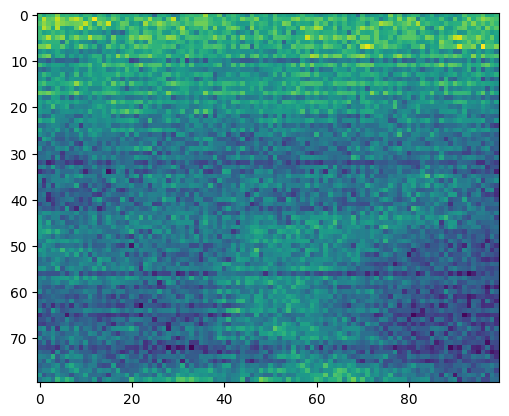

In [46]:
box_width = 100
box_height = 40

In [47]:
x, y = 10680, 4664

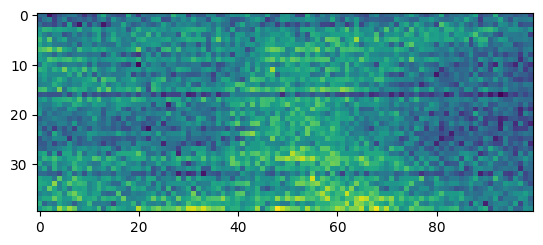

In [48]:
plt.imshow(b6_image_corrected[x:x + box_height, y: y + box_width])

In [49]:
np.mean(b6_image_corrected[x:x + box_height, y: y + box_width])

1446.5595

In [50]:
np.mean(b6_image_corrected[x:x + box_height, y: y + box_width])

1446.5595

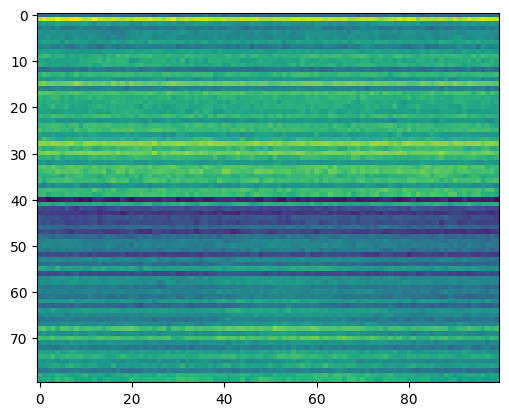

In [94]:
plt.imshow(b6_image[x:x + box_height, y: y + box_width])

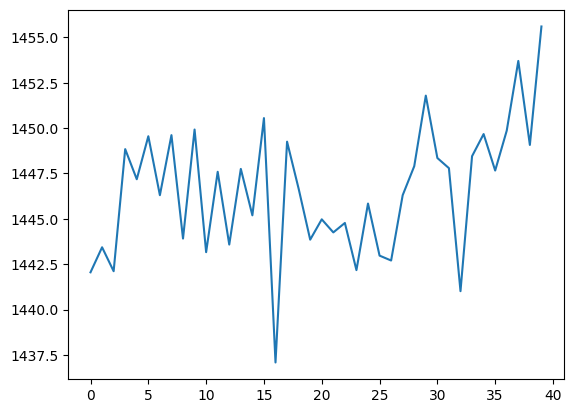

In [51]:
plt.plot(np.arange(40), np.mean(b6_image_corrected[x:x + box_height, y: y + box_width], axis=1))

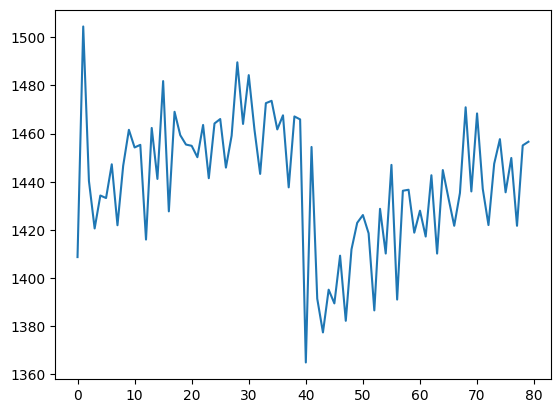

In [93]:
plt.plot(np.arange(80), np.mean(b6_image[x:x + box_height, y: y + box_width], axis=1))

In [86]:
x, y = 10680, 4664

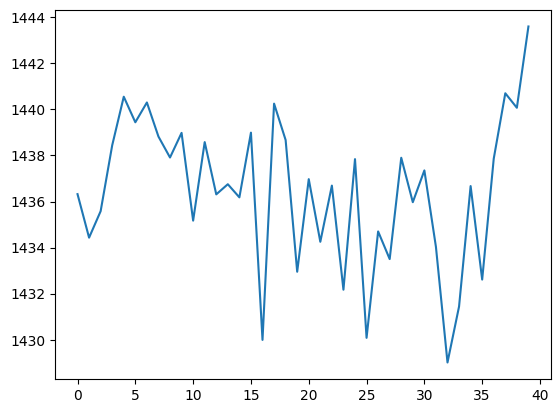

In [84]:
plt.plot(np.arange(40), np.mean(b6_image_corrected[x:x + box_height, y: y + box_width], axis=1))

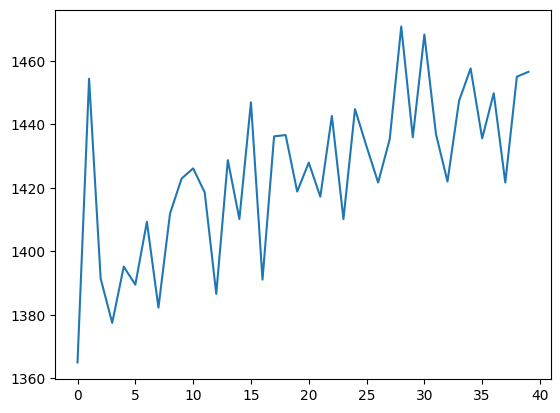

In [87]:
plt.plot(np.arange(40), np.mean(b6_image[x:x + box_height, y: y + box_width], axis=1))

In [40]:
sv_b6_data_corrected = apply_coeff_for_telemetry(sv_b6_data, alpha, beta)

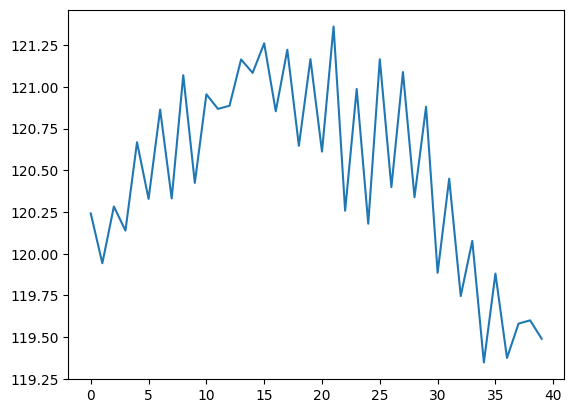

In [42]:
plt.plot(np.arange(40), np.mean(sv_b6_data_corrected[0::2], axis=(0, 2)))

In [43]:
voc_b6_data_corrected = apply_coeff_for_telemetry(voc_b6_data, alpha, beta)

In [102]:
bb_b6_data_corrected = apply_coeff_for_telemetry(bb_b6_data, alpha, beta)

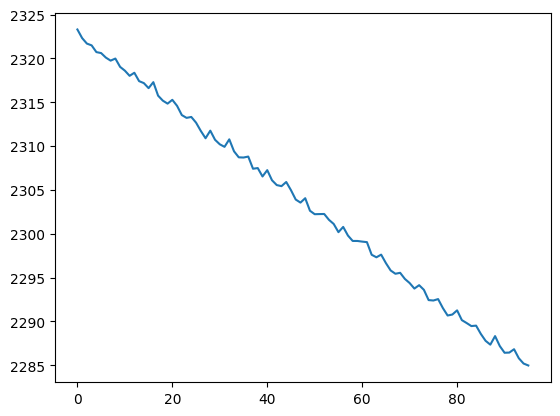

In [66]:
plt.plot(np.arange(96), np.mean(voc_b6_data[:, ::40, :], axis=(0, 1)))

In [68]:
bb_b6_data_1_mirror = bb_b6_data[::2]
bb_b6_data_2_mirror = bb_b6_data[1::2]

In [103]:
bb_b6_data_1_mirror_corr = bb_b6_data_corrected[::2]
bb_b6_data_2_mirror_corr = bb_b6_data_corrected[1::2]

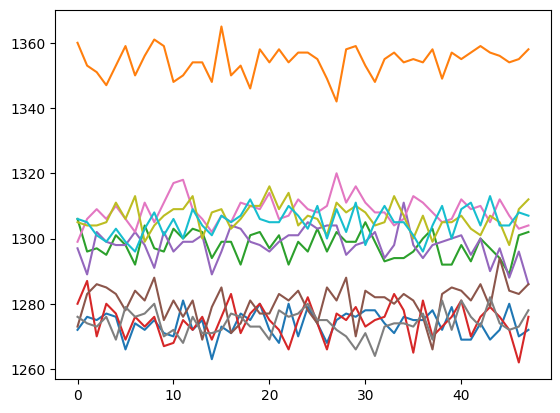

In [99]:
for i in range(10):
    plt.plot(np.arange(48), bb_b6_data_1_mirror[0, i, :])

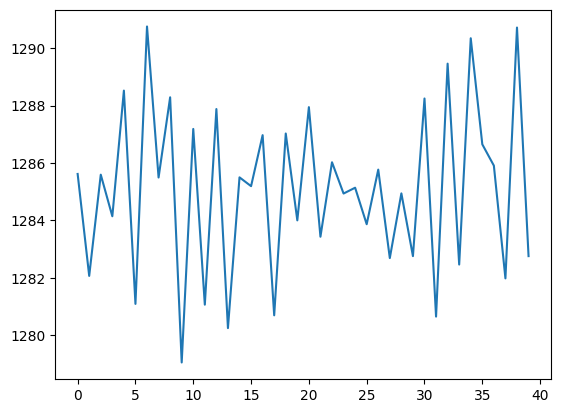

In [110]:
plt.plot(np.arange(40), np.mean(bb_b6_data_1_mirror_corr[0], axis=1))

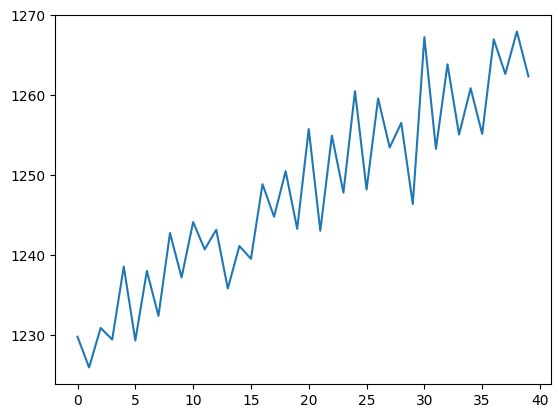

In [119]:
plt.plot(np.arange(40), np.mean(bb_b6_data_2_mirror_corr[0], axis=1))

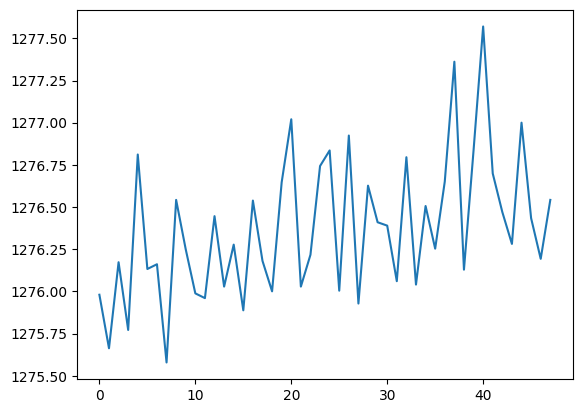

In [98]:
plt.plot(np.arange(48), np.mean(bb_b6_data_1_mirror[:, ::40, :], axis=(0, 1)))

In [73]:
voc_b6_data_1_mirror = voc_b6_data[::2]
voc_b6_data_2_mirror = voc_b6_data[1::2]

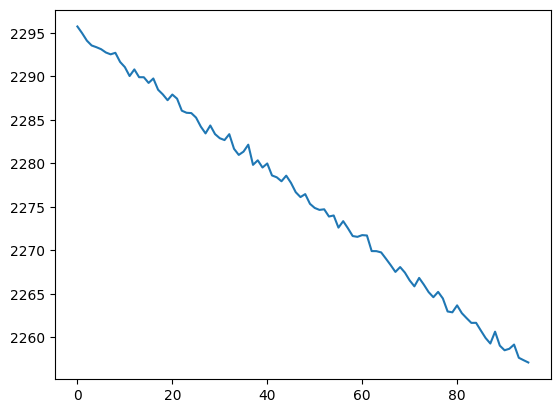

In [75]:
plt.plot(np.arange(96), np.mean(voc_b6_data_2_mirror[:, ::40, :], axis=(0, 1)))

In [76]:
sv_b6_data_1_mirror = sv_b6_data[::2]
sv_b6_data_2_mirror = sv_b6_data[1::2]

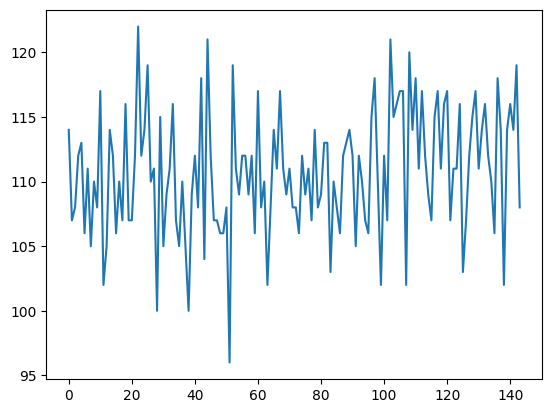

In [82]:
plt.plot(np.arange(144), sv_b6_data_2_mirror[:, ::40, :][0][0])

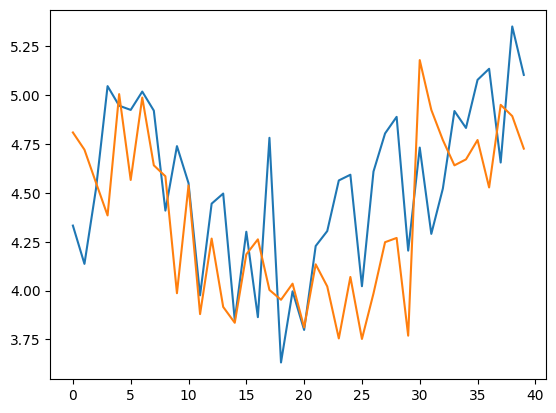

In [96]:
plt.plot(np.arange(40), np.std(sv_b6_data_1_mirror[0, :, :], axis=1))
plt.plot(np.arange(40), np.std(sv_b6_data_2_mirror[0, :, :], axis=1))

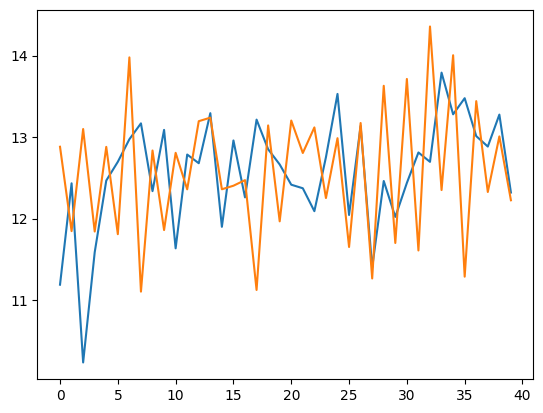

In [97]:
plt.plot(np.arange(40), np.std(voc_b6_data_1_mirror[0, :, :], axis=1))
plt.plot(np.arange(40), np.std(voc_b6_data_2_mirror[0, :, :], axis=1))

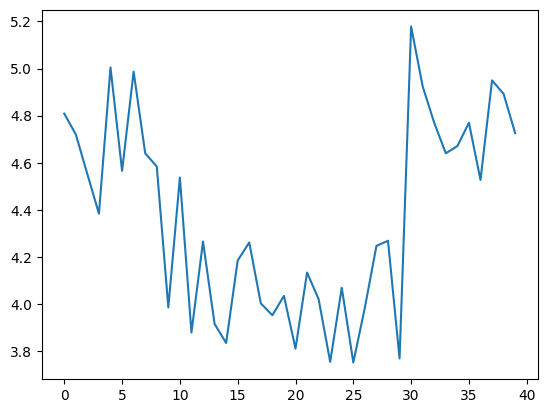

In [92]:
plt.plot(np.arange(40), np.std(sv_b6_data_2_mirror[0, :, :], axis=1))

In [80]:
np.std()

0.0

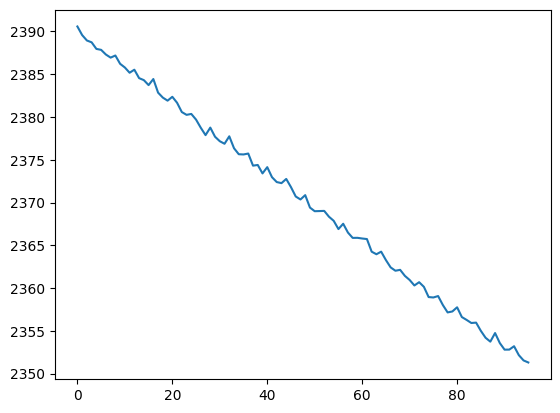

In [67]:
plt.plot(np.arange(96), np.mean(voc_b6_data_corrected[:, ::40, :], axis=(0, 1)))

In [61]:
np.std(voc_b6_data[:, ::40, :], axis=(0, 2))

array([30.19185892])

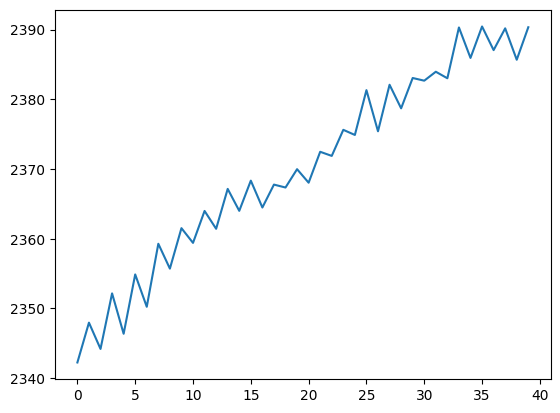

In [45]:
plt.plot(np.arange(40), np.mean(voc_b6_data_corrected[1::2], axis=(0, 2)))

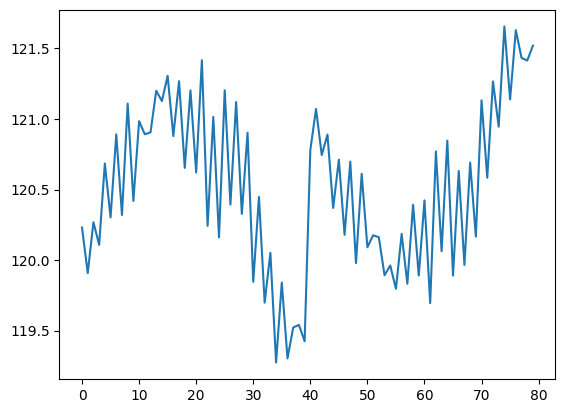

In [115]:
plt.plot(np.arange(80), np.concatenate([np.mean(sv_b6_data_corrected[::2], axis=(0, 2)), np.mean(sv_b6_data_corrected[1::2], axis=(0, 2))]))

In [58]:
bb_b6_data_corrected = apply_coeff_for_telemetry(bb_b6_data, alpha, beta)

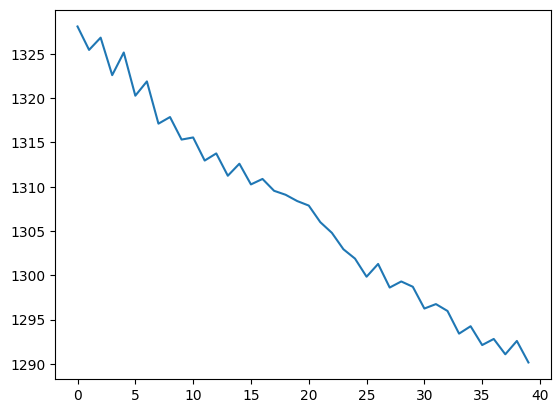

In [59]:
plt.plot(np.arange(40), np.mean(bb_b6_data_corrected[::2], axis=(0, 2)))

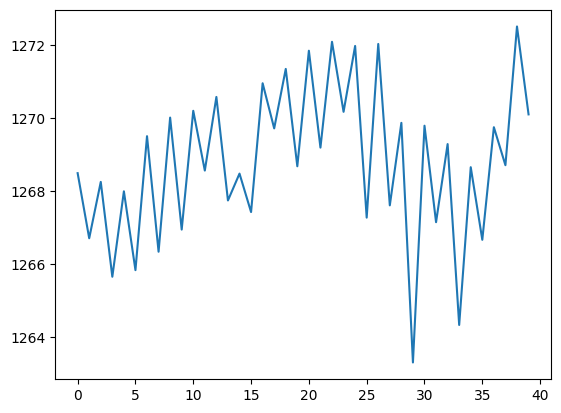

In [60]:
plt.plot(np.arange(40), np.mean(bb_b6_data_corrected[1::2], axis=(0, 2)))

In [78]:
voc_b6_data_corrected = np.zeros(voc_b6_data.shape)

for i in range(voc_b6_data.shape[0]):
    voc_b6_data_corrected[i] = alpha[..., None][(i // 40) % 2] * voc_b6_data[i] + beta[..., None][(i // 40) % 2]

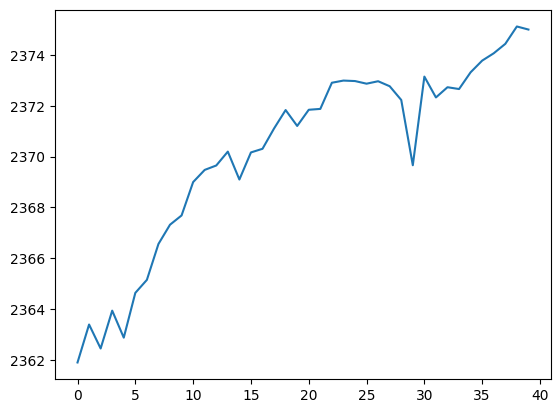

In [79]:
plt.plot(np.arange(40), np.mean(voc_b6_data_corrected[1::2], axis=(0, 2)))

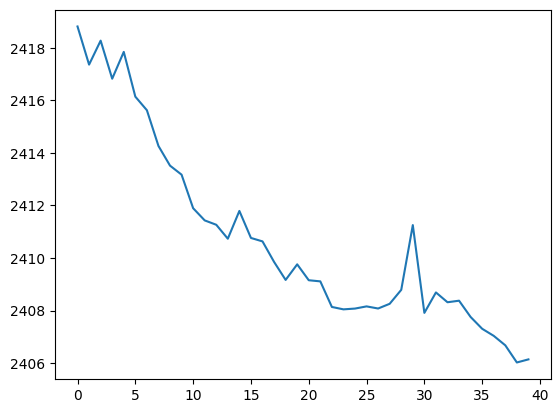

In [80]:
plt.plot(np.arange(40), np.mean(voc_b6_data_corrected[::2], axis=(0, 2)))

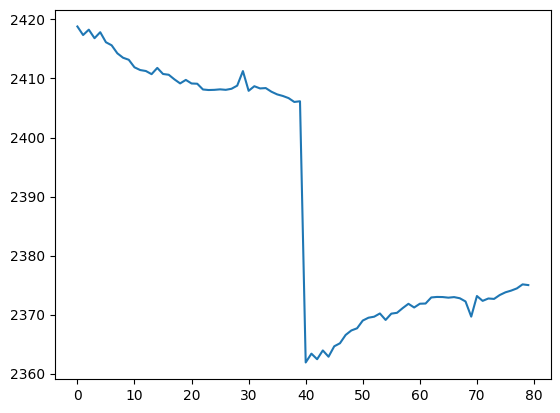

In [82]:
plt.plot(np.arange(80), np.concatenate([np.mean(voc_b6_data_corrected[::2], axis=(0, 2)), np.mean(voc_b6_data_corrected[1::2], axis=(0, 2))]))

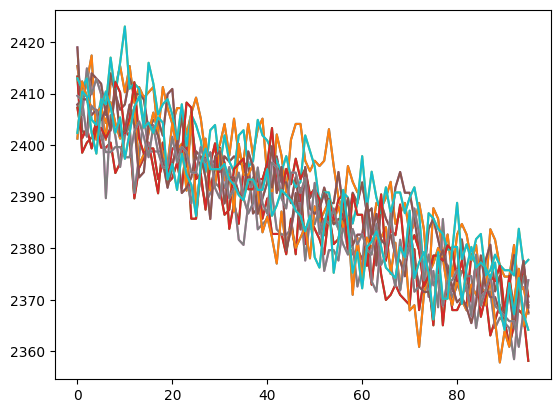

In [102]:
for i in range(10):
    plt.plot(np.arange(96), voc_b6_data_corrected[2][i])
    plt.plot(np.arange(96), voc_b6_data_corrected[2][i])

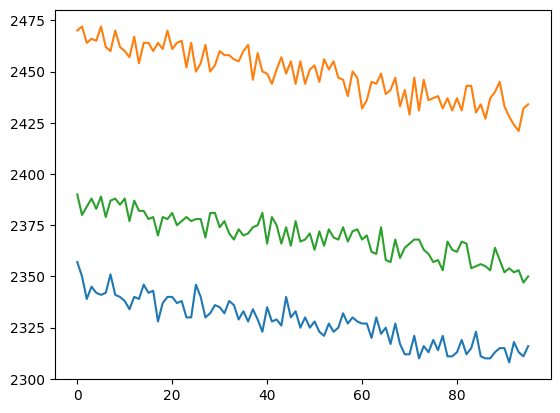

In [100]:
for i in range(3):
    plt.plot(np.arange(96), voc_b6_data[0][i])

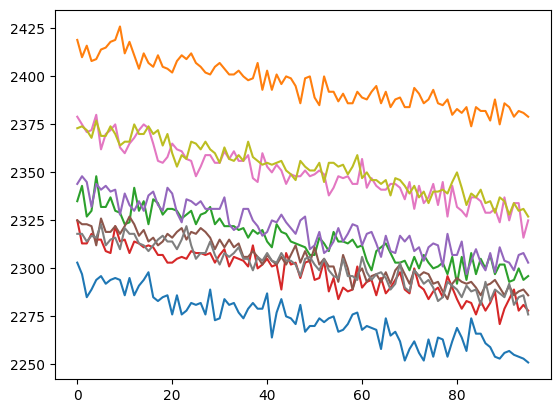

In [170]:
for i in range(9):
    plt.plot(np.arange(96), voc_b6_data[1][i])

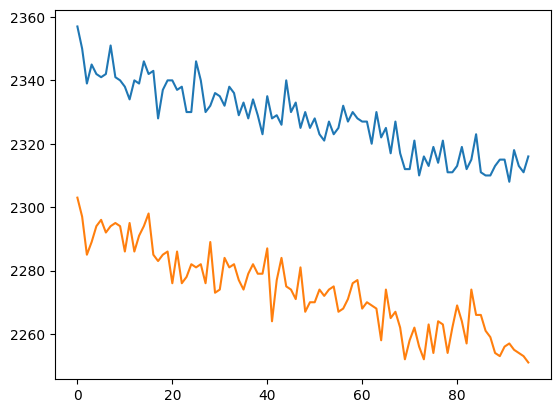

In [171]:
plt.plot(np.arange(96), voc_b6_data[0][0])
plt.plot(np.arange(96), voc_b6_data[1][0])

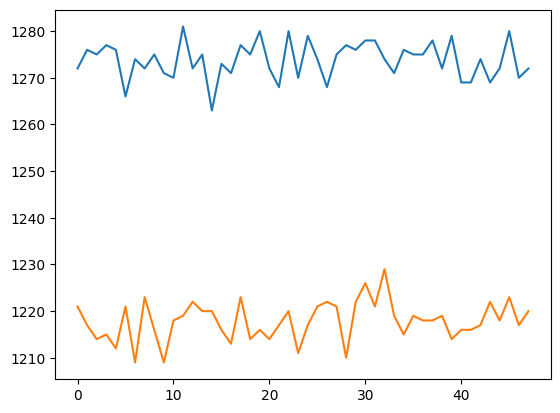

In [172]:
plt.plot(np.arange(48), bb_b6_data[0][0])
plt.plot(np.arange(48), bb_b6_data[1][0])

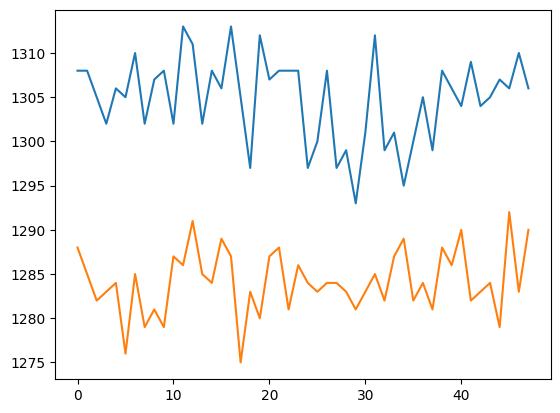

In [173]:
plt.plot(np.arange(48), bb_b6_data[0][39])
plt.plot(np.arange(48), bb_b6_data[1][39])

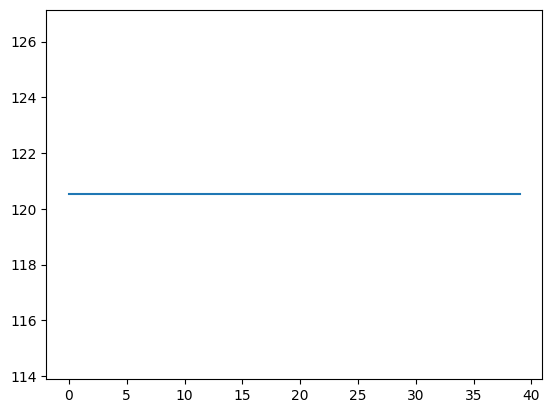

In [83]:
plt.plot(np.arange(40), sv_b6_sensors_mean[1] * alpha[1] + beta[1])

In [178]:
np.mean(sv_b6_sensors_mean[1] * alpha[1] + beta[1])

120.51761594991076

In [179]:
np.mean(sv_b6_sensors_mean[0] * alpha[0] + beta[0])

120.51761594991076

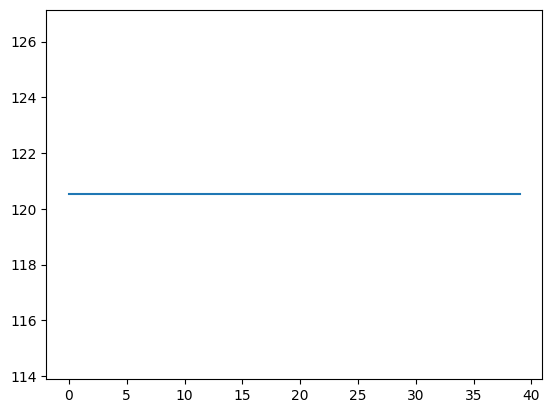

In [84]:
plt.plot(np.arange(40), sv_b6_sensors_mean[1] * alpha[1] + beta[1])

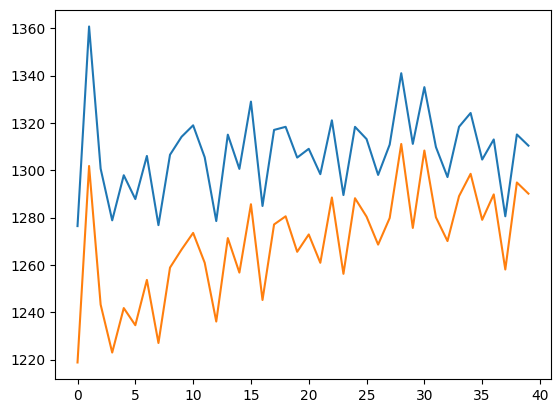

In [105]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0])
plt.plot(np.arange(40), bb_b6_sensors_mean[1])

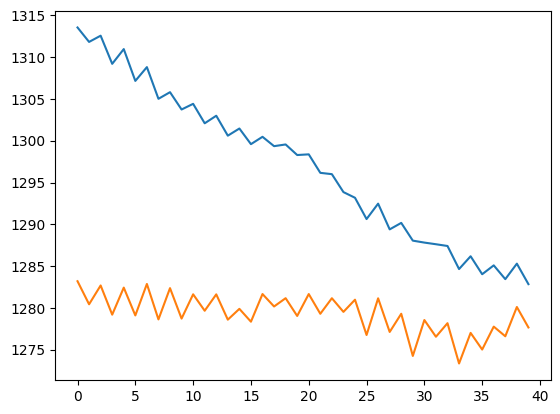

In [104]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0] * alpha[0] + beta[0])
plt.plot(np.arange(40), bb_b6_sensors_mean[1] * alpha[1] + beta[1])
#plt.yticks(np.arange(np.min(voc_b6_sensors_mean[1] * alpha[0] + beta[0]), np.max(voc_b6_sensors_mean[0] * alpha[1] + beta[1]), 10))

([<matplotlib.axis.YTick at 0x25727bd6250>,
 [Text(0, 2287.787739511697, '2287.8'),
  Text(0, 2297.787739511697, '2297.8'),
  Text(0, 2307.787739511697, '2307.8'),
  Text(0, 2317.787739511697, '2317.8'),
  Text(0, 2327.787739511697, '2327.8'),
  Text(0, 2337.787739511697, '2337.8'),
  Text(0, 2347.787739511697, '2347.8'),
  Text(0, 2357.787739511697, '2357.8'),
  Text(0, 2367.787739511697, '2367.8'),
  Text(0, 2377.787739511697, '2377.8'),
  Text(0, 2387.787739511697, '2387.8'),
  Text(0, 2397.787739511697, '2397.8'),
  Text(0, 2407.787739511697, '2407.8'),
  Text(0, 2417.787739511697, '2417.8'),
  Text(0, 2427.787739511697, '2427.8'),
  Text(0, 2437.787739511697, '2437.8'),
  Text(0, 2447.787739511697, '2447.8'),
  Text(0, 2457.787739511697, '2457.8')])

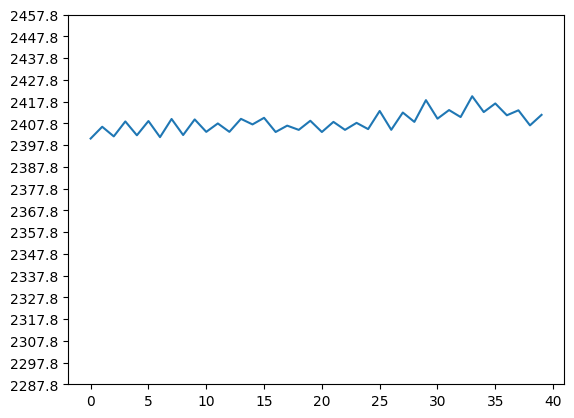

In [174]:
plt.plot(np.arange(40), voc_b6_sensors_mean[1] * alpha[1] + beta[1])
plt.yticks(np.arange(np.min(voc_b6_sensors_mean[1] * alpha[0] + beta[0]), np.max(voc_b6_sensors_mean[0] * alpha[1] + beta[1]), 10))

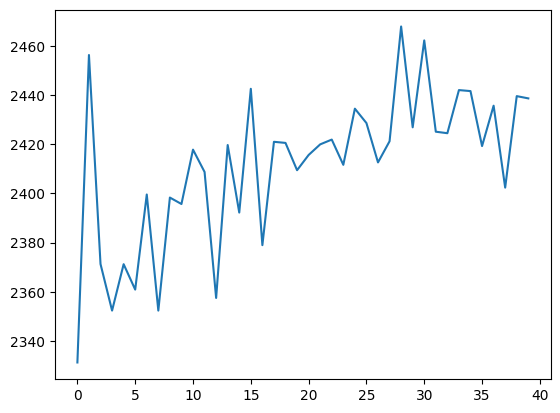

In [103]:
plt.plot(np.arange(40), voc_b6_sensors_mean[0])

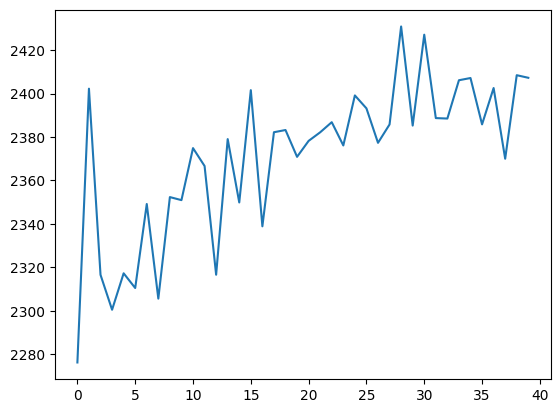

In [120]:
plt.plot(np.arange(40), voc_b6_sensors_mean[1])

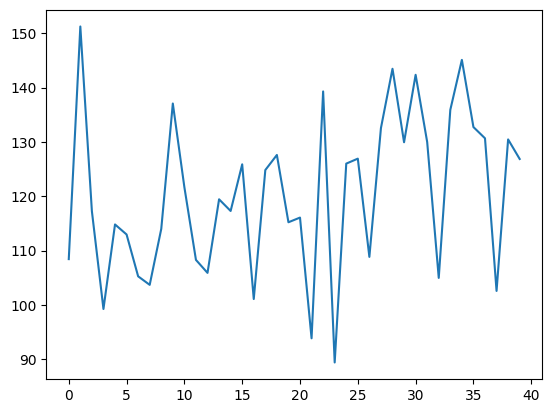

In [125]:
plt.plot(np.arange(40), sv_b6_sensors_mean[0])

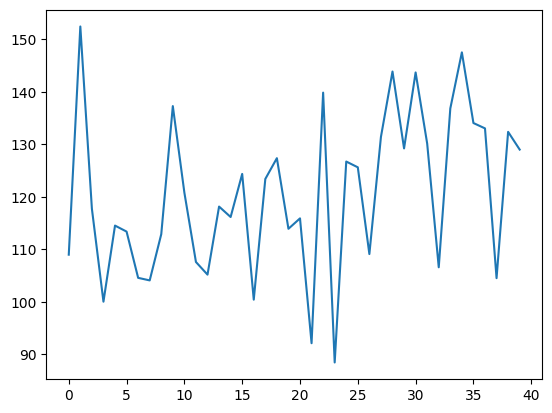

In [126]:
plt.plot(np.arange(40), sv_b6_sensors_mean[1])

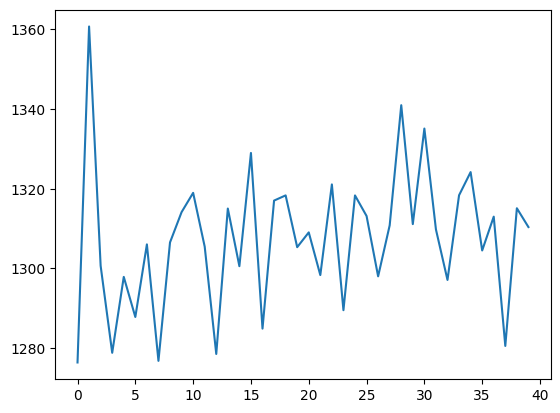

In [127]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0])

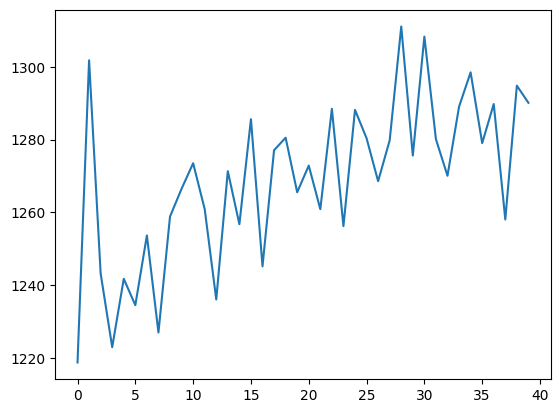

In [128]:
plt.plot(np.arange(40), bb_b6_sensors_mean[1])

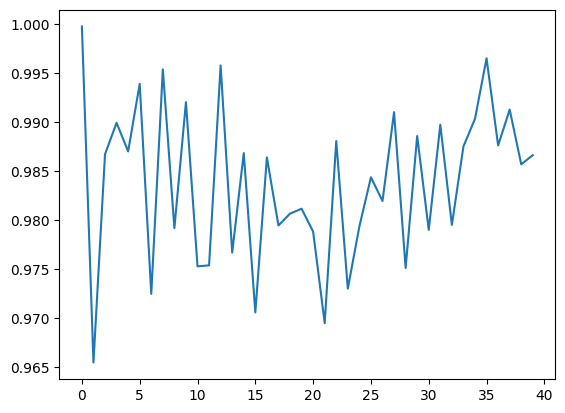

In [129]:
plt.plot(np.arange(40), alpha[0])

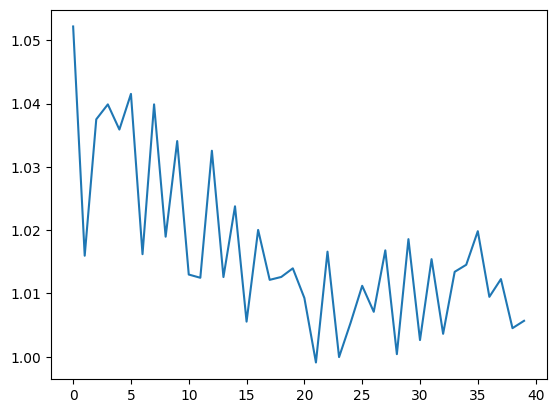

In [130]:
plt.plot(np.arange(40), alpha[1])

In [ ]:
plt.plot(np.arange(40), beta[0])
plt.yticks(np.arange(np.min(beta), np.max(beta), 10))

In [ ]:
plt.plot(np.arange(40), beta[1])
plt.yticks(np.arange(np.min(beta), np.max(beta), 10))

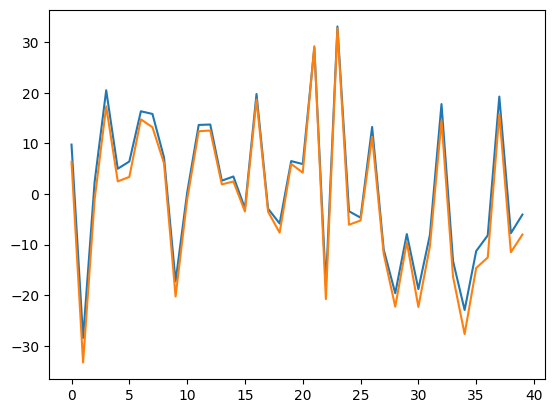

In [121]:
plt.plot(np.arange(40), beta[0])
plt.plot(np.arange(40), beta[1])

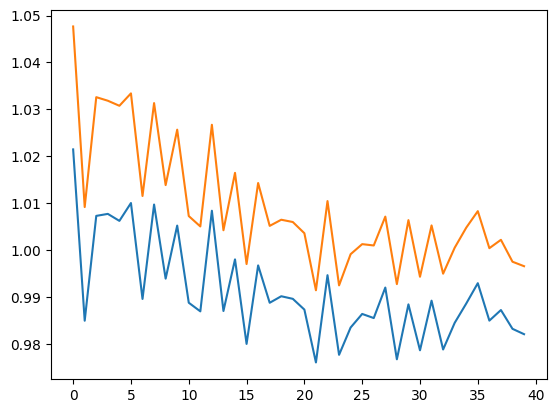

In [120]:
plt.plot(np.arange(40), alpha[0])
plt.plot(np.arange(40), alpha[1])

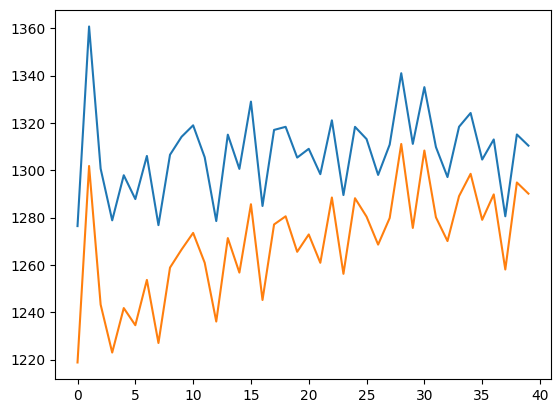

In [122]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0])
plt.plot(np.arange(40), bb_b6_sensors_mean[1])

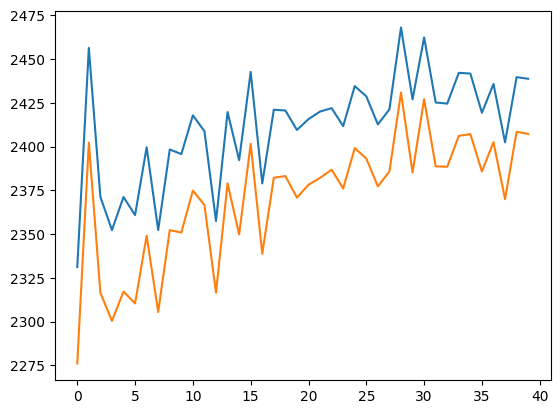

In [123]:
plt.plot(np.arange(40), voc_b6_sensors_mean[0])
plt.plot(np.arange(40), voc_b6_sensors_mean[1])

In [124]:
section_1_corrected[80:120].shape

(40, 6144)

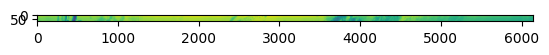

In [125]:
plt.imshow(section_1_corrected[80:160])

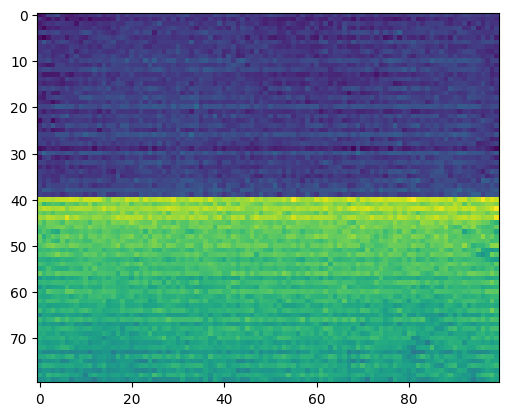

In [126]:
plt.imshow(section_1_corrected[120:200][:, 1450:1550])

In [228]:
diff = section_1_corrected[120:160][:, 1450:1550] - section_1_corrected[160:200][:, 1450:1550]

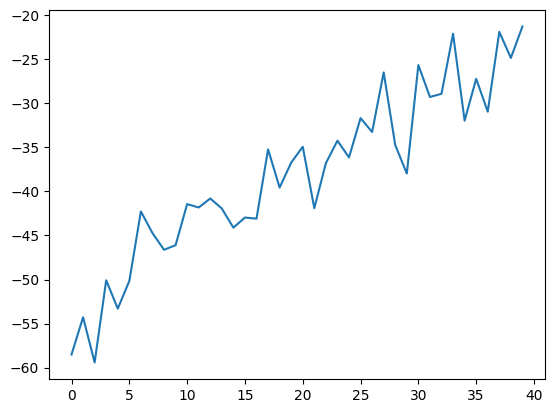

In [229]:
plt.plot(np.arange(40), np.mean(diff, axis=1))

In [212]:
bb_diff = bb_b6_data_corrected[0] - bb_b6_data_corrected[1]

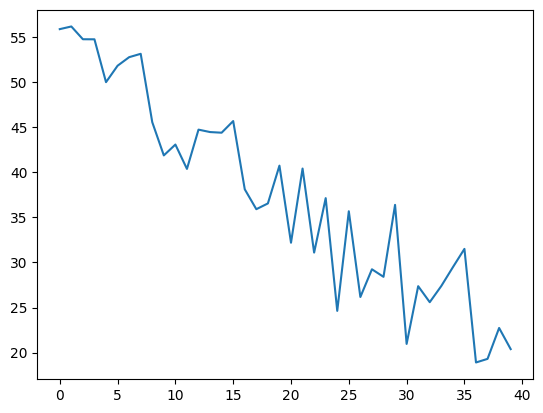

In [213]:
plt.plot(np.arange(40), np.mean(bb_diff, axis=1))

In [201]:
np.mean(diff, axis=1).shape

(40,)

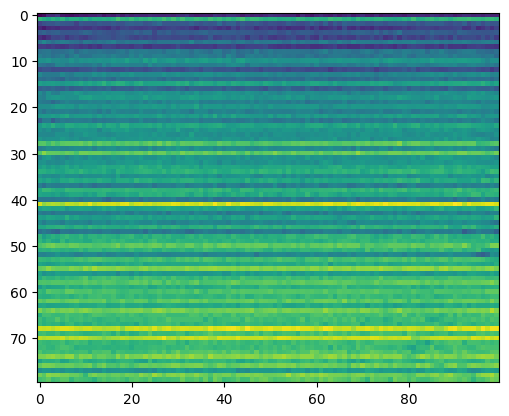

In [219]:
plt.imshow(section_1[120:200][:, 1450:1550])

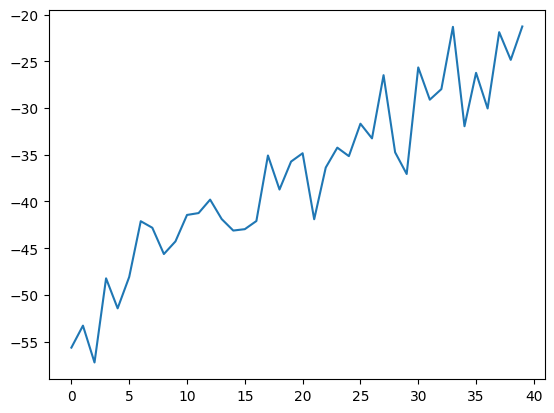

In [222]:
diff = section_1[120:160][:, 1450:1550].astype(dtype=np.int16) - section_1[160:200][:, 1450:1550].astype(dtype=np.int16)
plt.plot(np.arange(40), np.mean(diff, axis=1))

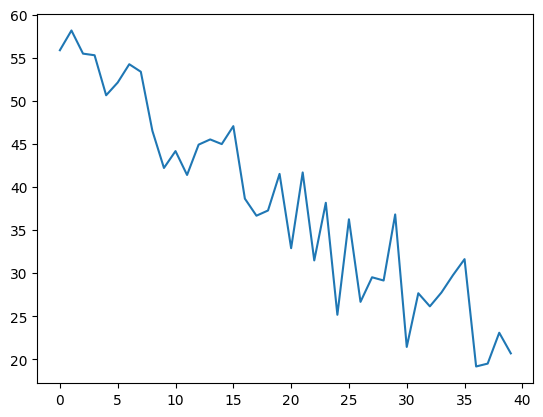

In [224]:
bb_diff = bb_b6_data[0].astype(dtype=np.int16) - bb_b6_data[1].astype(dtype=np.int16)
plt.plot(np.arange(40), np.mean(bb_diff, axis=1))